IMPORT THƯ VIỆN VÀ DATA

In [7]:
import pandas as pd
import numpy as np

sales = pd.read_csv("Dataset/preprocess/Sales_clean.csv")
product = pd.read_csv("Dataset/preprocess/Product_clean.csv")
channel = pd.read_csv("Dataset/preprocess/Channel_clean.csv")
cogs = pd.read_csv("Dataset/preprocess/COGS_clean.csv")

print("Chi tiết bảng Sales: ",sales.shape)
print(sales.head())
print("Chi tiết bảng Product: ",product.shape)
print(product.head())
print("Chi tiết bảng Channel: ",channel.shape)
print(channel.head())
print("Chi tiết bảng COGS: ",cogs.shape)
print(cogs.head())

Chi tiết bảng Sales:  (764916, 10)
     week    month  site  branch_id channel_id distribution_channel_code  \
0  202201  2022001  1800       1800     Online                       ZF2   
1  202204  2022001  1116       1100       CHTT                        FP   
2  202201  2022001  1134       1100       CHTT                        FP   
3  202204  2022001  1612       1600       CHTT                        FP   
4  202202  2022001  1511       1500       CHTT                        FP   

   sold_quantity  net_price  cost_price                             product_id  
0              1     729000      495720  d77fdd34a14845db97837e059b0aca00TRG42  
1              1     325000      221000  e485c0ab7b9b470cbddb80ea7367e734DEN40  
2              1     375000      255000  ac88f78262ee4b589bc93b106b67af1dDEN42  
3              1     380000      258400  920641c624934c4a8695347737f8f59dDEN35  
4              1     400000      272000  6764565f4bb141138af7d9cbf0905d0dHOL33  
Chi tiết bảng Product:

TẠO CÁC FEATURE VỀ DỮ LIỆU BÁN HÀNG

In [8]:
#Doanh thu
sales['revenue'] = sales['sold_quantity'] * sales['net_price']
#Lợi nhuận
sales['profit'] = (sales['net_price'] - sales['cost_price']) * sales['sold_quantity']
#Tỷ suất lợi nhuận biên -> doanh nghiệp thu được bao nhiêu lợi nhuận trên mỗi đồng doanh thu
sales['margin_rate'] = (sales['net_price'] - sales['cost_price']) / sales['net_price']
#Nếu muốn đối chiếu giữa giá vốn thực tế trong bảng sales và giá vốn chuẩn (standard COGS) trong bảng cogs
#sales = sales.merge(cogs, on='product_id', how='left', suffixes=('', '_cogs'))
#sales['profit_std'] = (sales['net_price'] - sales['amount']) * sales['sold_quantity']


In [9]:
# Kiểm tra trùng lặp product_id trong bảng product
duplicates = product[product.duplicated(subset='product_id', keep=False)]

if not duplicates.empty:
    print(f"Số lượng product_id bị trùng: {duplicates['product_id'].nunique()}")
    print("Các product_id bị trùng và số lần xuất hiện:")
    print(duplicates['product_id'].value_counts().head(10))
    print("\nChi tiết vài dòng đầu:")
    print(duplicates.head(10))
else:
    print("Không có product_id nào bị trùng trong bảng product.")


Không có product_id nào bị trùng trong bảng product.


In [10]:
#Tỷ lệ chiết khấu
price_map = product.set_index('product_id')['listing_price']
sales['listing_price'] = sales['product_id'].map(price_map)
sales['discount_rate'] = np.where(
    sales['listing_price'].notna() & (sales['listing_price']>0),
    (sales['listing_price'] - sales['net_price']) / sales['listing_price'],
    0.0
)
sales['discount_rate'] = sales['discount_rate'].clip(lower=0)

# Cờ khuyến mãi theo 3 mức độ
sales['promo_flag'] = np.where( sales['discount_rate'] >= 0.5, 2,             # Nếu giảm mạnh (≥50%) → 2
                      np.where( (sales['discount_rate'] > 0) & (sales['discount_rate'] < 0.5), 1, 0))

In [11]:
#Kiểm tra biến doanh thu
print("sold_quantity: ",sales['sold_quantity'].iloc[7])
print("net_price: ",sales['net_price'].iloc[7])
print("revenue: ",sales['revenue'].iloc[7])
print()
#Kiểm tra biến cờ khuyến mãi
print("listing_price: ",sales['listing_price'].iloc[12])
print("net_price: ",sales['net_price'].iloc[12])
print("discount_rate: ",sales['discount_rate'].iloc[12])
print("promo_flag: ",sales['promo_flag'].iloc[12])
print(sales.head(20))

sold_quantity:  10
net_price:  645000
revenue:  6450000

listing_price:  199000.0
net_price:  569000
discount_rate:  0.0
promo_flag:  0
      week    month  site  branch_id channel_id distribution_channel_code  \
0   202201  2022001  1800       1800     Online                       ZF2   
1   202204  2022001  1116       1100       CHTT                        FP   
2   202201  2022001  1134       1100       CHTT                        FP   
3   202204  2022001  1612       1600       CHTT                        FP   
4   202202  2022001  1511       1500       CHTT                        FP   
5   202204  2022001  1407       1400       CHTT                        FP   
6   202204  2022001  1104       1100       CHTT                        FP   
7   202202  2022001  1100       1100       TGPP                       ZF2   
8   202202  2022001  1140       1100       CHTT                        FP   
9   202201  2022001  1250       1200       CHTT                        FP   
10  202202  20220

TẠO CÁC FEATURE MÙA VỤ

In [12]:
sales = sales[sales['week'] != 202352]

In [13]:
import holidays
sales['week_num'] = sales['week'].astype(str).str[-2:].astype(int)
sales['month_num'] = sales['month'].astype(str).str[-2:].astype(int)
sales['year_num'] = sales['month'].astype(str).str[:4].astype(int)
sales['quarter'] = (sales['month_num']-1)//3 + 1
sales['season'] = sales['month_num'].map({1:'Spring',2:'Spring',3:'Spring',4:'Summer',
                                      5:'Summer',6:'Summer',7:'Autumn',8:'Autumn',
                                      9:'Autumn',10:'Winter',11:'Winter',12:'Winter'})
#Tạo holiday_flag
start = pd.to_datetime('2021-12-20')   # bắt trước tuần 53/2021
end   = pd.to_datetime('2023-08-10')   # bao phủ qua tuần 31/2023

vn_holidays = holidays.Vietnam(years=[2021,2022,2023])

holiday_week_set = set()
for single_date in pd.date_range(start, end):
    if single_date in vn_holidays:
        iso = single_date.isocalendar()  # (year, week, weekday)
        iso_year = iso.year
        iso_week = iso.week
        holiday_week_set.add((iso_year, iso_week))

sales['holiday_flag'] = sales.apply(
    lambda r: 1 if (r['year_num'], r['week_num']) in holiday_week_set else 0, axis=1)


Do dự báo theo tuần, nhóm chuyển biến week về dạng số tuần (int) để tính lag/rolling thay vì dạng chuỗi số

In [14]:
#Check biến mới tạo
print(sales.head(2))
print()
print("Số tuần có ít nhất 1 ngày lễ trong khoảng tháng 01/2022 - 07/2023:", len(holiday_week_set))
print(sorted(list(holiday_week_set)))

     week    month  site  branch_id channel_id distribution_channel_code  \
0  202201  2022001  1800       1800     Online                       ZF2   
1  202204  2022001  1116       1100       CHTT                        FP   

   sold_quantity  net_price  cost_price  \
0              1     729000      495720   
1              1     325000      221000   

                              product_id  ...  margin_rate  listing_price  \
0  d77fdd34a14845db97837e059b0aca00TRG42  ...         0.32       736364.0   
1  e485c0ab7b9b470cbddb80ea7367e734DEN40  ...         0.32       324000.0   

   discount_rate  promo_flag  week_num  month_num  year_num  quarter  season  \
0           0.01           1         1          1      2022        1  Spring   
1           0.00           0         4          1      2022        1  Spring   

   holiday_flag  
0             1  
1             0  

[2 rows x 22 columns]

Số tuần có ít nhất 1 ngày lễ trong khoảng tháng 01/2022 - 07/2023: 14
[(2021, 52), (2022, 

TẠO CÁC FEATURE LỊCH SỬ

In [15]:
sales_weekly = (
    sales.groupby(['product_id', 'week'], as_index=False)
    .agg({
        'sold_quantity': 'sum',
        'net_price': 'mean',
        'cost_price': 'mean',
        'revenue': 'sum',
        'profit': 'sum'
    })
)
# Sắp xếp theo sản phẩm và tuần
sales_weekly = sales_weekly.sort_values(by=['product_id', 'week'])

# Tổng số lượng bán của tuần trước đó -> Nhu cầu tuần trước
sales_weekly['lag_1'] = sales_weekly.groupby('product_id')['sold_quantity'].shift(1)

# Trung bình số lượng bán ra của 4 tuần gần nhất (trừ tuần hiện tại)
sales_weekly['rolling_mean_4w'] = (
    sales_weekly.groupby('product_id')['sold_quantity']
    .apply(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

# Tốc độ tăng trưởng
sales_weekly['growth_rate'] = np.where(
    sales_weekly['lag_1'] > 0,
    (sales_weekly['sold_quantity'] - sales_weekly['lag_1']) / sales_weekly['lag_1'],
    0.0
)

# Điền giá trị khuyết
sales_weekly[['lag_1', 'rolling_mean_4w', 'growth_rate']] \
    = sales_weekly[['lag_1', 'rolling_mean_4w', 'growth_rate']].fillna(0)

In [16]:
#Check
print(sales_weekly.head(10))

                              product_id    week  sold_quantity   net_price  \
0  000108ac94864037b89c6d7ce78d1134KEM35  202210              1   220123.00   
1  000108ac94864037b89c6d7ce78d1134KEM35  202211              2   435396.00   
2  000108ac94864037b89c6d7ce78d1134KEM35  202212              2   217462.50   
3  000108ac94864037b89c6d7ce78d1134KEM35  202213             10   548040.25   
4  000108ac94864037b89c6d7ce78d1134KEM35  202214              1   226466.00   
5  000108ac94864037b89c6d7ce78d1134KEM35  202217              6  1303362.00   
6  000108ac94864037b89c6d7ce78d1134KEM35  202219              5   290000.00   
7  000108ac94864037b89c6d7ce78d1134KEM35  202220              4   290000.00   
8  000108ac94864037b89c6d7ce78d1134KEM35  202221              6   324683.60   
9  000108ac94864037b89c6d7ce78d1134KEM35  202222              1   276000.00   

   cost_price  revenue  profit  lag_1  rolling_mean_4w  growth_rate  
0   196952.00   220123   23171    0.0         0.000000     0

ĐỐNG DƯỚI NÀY T TÍNH NHÁP THỬ COI MÔ HÌNH CÓ TƯƠNG QUAN HAY ĐÚNG MẤY CHỈ SỐ KINH TẾ KO

ĐỘ CO GIÃN VỀ GIÁ

In [10]:
import statsmodels.api as sm
import numpy as np

# Loại bỏ dữ liệu null hoặc giá <=0
df_elastic = sales[(sales['sold_quantity'] > 0) & (sales['net_price'] > 0)].copy()
df_elastic['log_Q'] = np.log(df_elastic['sold_quantity'])
df_elastic['log_P'] = np.log(df_elastic['net_price'])

# Ước lượng elasticity theo từng sản phẩm (hoặc toàn bộ)
model = sm.OLS(df_elastic['log_Q'], sm.add_constant(df_elastic['log_P'])).fit()
elasticity = model.params['log_P']
print(f"Elasticity ước lượng (toàn bộ tập): {elasticity:.2f}")

Elasticity ước lượng (toàn bộ tập): 0.14


-> Khi giá tăng 1%, lượng bán trung bình tăng 0.14%. Thông thường, độ co giãn cầu theo giá (price elasticity of demand) phải là âm vì khi giá tăng thì cầu giảm (quy luật cầu).
-> CÁI NÀY CHƯA XÉT YẾU TỐ MÙA VỤ, KHUYẾN MÃI... NÊN CÓ THỂ SAI -> KHI CHẠY MÔ HÌNH CẦN XEM XÉT THÊM

In [11]:
elasticity_by_product = (
    df_elastic.groupby('product_id')
    .apply(lambda g: sm.OLS(g['log_Q'], sm.add_constant(g['log_P'])).fit().params['log_P'])
)
elasticity_by_product = elasticity_by_product.reset_index()
elasticity_by_product.columns = ['product_id', 'elasticity']

# Xem tỉ lệ sản phẩm có elasticity âm/dương
neg_ratio = (elasticity_by_product['elasticity'] < 0).mean()
print(f"Tỷ lệ sản phẩm có độ co giãn âm: {neg_ratio:.1%}")

Tỷ lệ sản phẩm có độ co giãn âm: 0.1%


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_8372\2899471054.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: sm.OLS(g['log_Q'], sm.add_constant(g['log_P'])).fit().params['log_P'])


XỬ LÝ CÁC MISSING VÀ OUTLIER SAU KHI FEATUTE ENGINEERING

In [20]:
# Kiểm tra tổng số giá trị missing data trên mỗi cột
sales_missing_summary = sales.isnull().sum()
sales_weekly_missing_summary = sales_weekly.isnull().sum()
print("Tổng số giá trị thiếu của bảng Sales trên mỗi cột:\n", sales_missing_summary)
print("\nTổng số giá trị thiếu của bảng Sales trên mỗi cột:\n", sales_weekly_missing_summary)


Tổng số giá trị thiếu của bảng Sales trên mỗi cột:
 week                           0
month                          0
site                           0
branch_id                      0
channel_id                     0
distribution_channel_code      0
sold_quantity                  0
net_price                      0
cost_price                     0
product_id                     0
revenue                        0
profit                         0
margin_rate                    0
listing_price                567
discount_rate                  0
promo_flag                     0
week_num                       0
month_num                      0
year_num                       0
quarter                        0
season                         0
holiday_flag                   0
dtype: int64

Tổng số giá trị thiếu của bảng Sales trên mỗi cột:
 product_id         0
week               0
sold_quantity      0
net_price          0
cost_price         0
revenue            0
profit             0
lag_1    

In [26]:
def check_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    n_outliers = len(outliers)

    if n_outliers > 0:
        print(f"\nCột '{column}' có {n_outliers} outlier:")
        print(outliers)

# Áp dụng cho từng cột bạn muốn kiểm tra
for col in ['sold_quantity', 'net_price', 'revenue', 'profit']:
    check_outliers_iqr(sales_weekly, col)


Cột 'sold_quantity' có 26338 outlier:
                                   product_id    week  sold_quantity  \
3       000108ac94864037b89c6d7ce78d1134KEM35  202213             10   
11      000108ac94864037b89c6d7ce78d1134KEM35  202225             15   
12      000108ac94864037b89c6d7ce78d1134KEM35  202226              7   
13      000108ac94864037b89c6d7ce78d1134KEM35  202227              7   
15      000108ac94864037b89c6d7ce78d1134KEM35  202229             21   
...                                       ...     ...            ...   
382660  fff0c748c1df4d3d87645319350a08c8XNH39  202213             12   
382689  fff28b16c8594ad8be06581db139c5e0XDG23  202233              7   
382713  fff7288cd45742d9a960e7f8c499effdVAG35  202227              9   
382716  fff7288cd45742d9a960e7f8c499effdVAG35  202231              8   
382749  fff951eb98dd4d629cde291619084be9DEN31  202244             11   

            net_price     cost_price   revenue   profit  lag_1  \
3       548040.250000  492381.

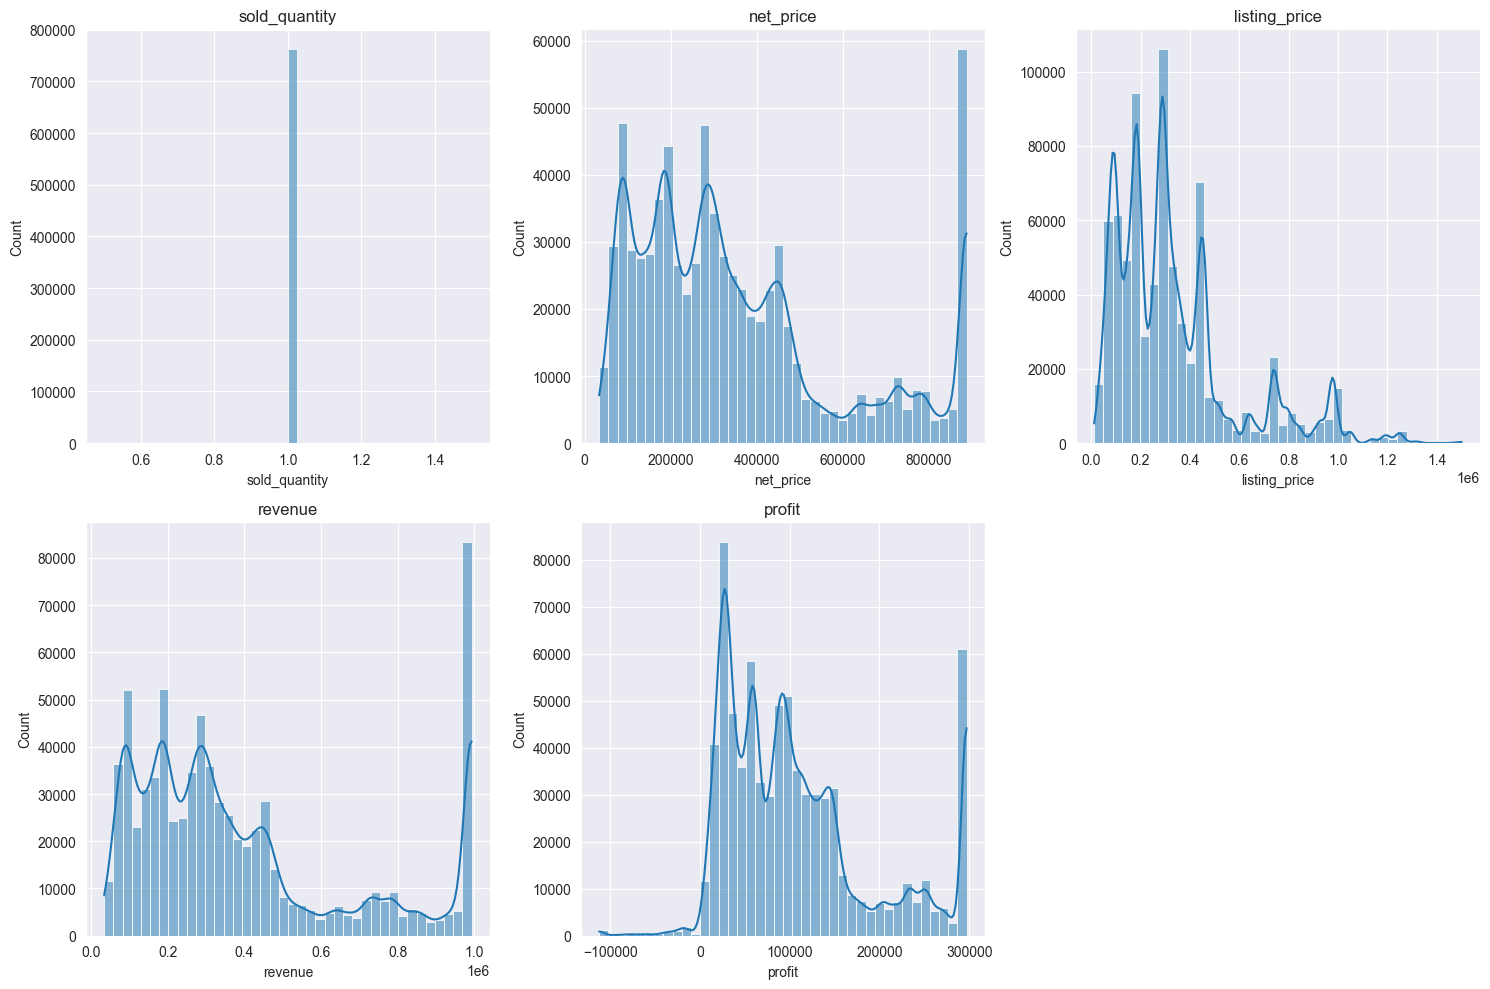

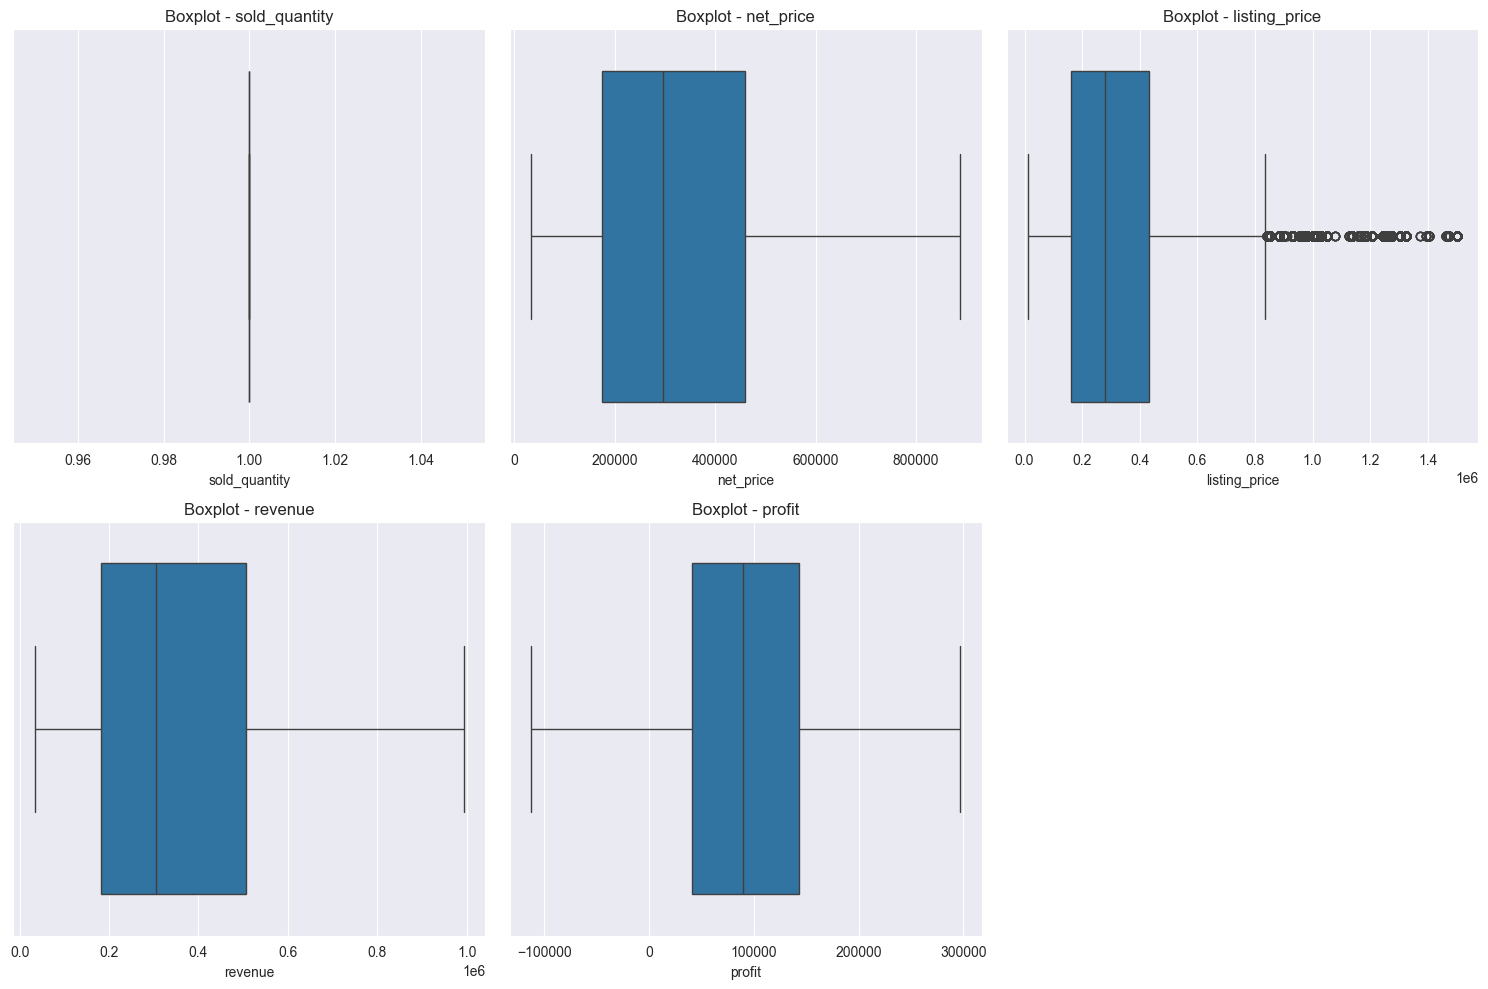

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# BIỂU ĐỒ THỐNG KÊ PHÂN PHỐI SAU KHI LÀM SẠCH
numeric_cols = ['sold_quantity', 'net_price', 'listing_price', 'revenue', 'profit']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(sales[col], bins=40, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# BIỂU ĐỒ HỘP (BOXPLOT) KIỂM TRA OUTLIER TRỰC QUAN
plt.figure(figsize=(15, 10))
for i, col in enumerate(['sold_quantity', 'net_price', 'listing_price', 'revenue', 'profit'], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=sales[col])
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

In [19]:
sales.to_csv("Dataset/preprocess/Sales_featured.csv", index=False, encoding='utf-8-sig')
sales_weekly.to_csv("Dataset/preprocess/Sales_weekly.csv", index=False, encoding='utf-8-sig')